In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap

def generate_very_hard_synthetic_data(n_samples=10000):
    np.random.seed(42)

    # Sürekli özellikler
    feature_0 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_1 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_2 = np.random.uniform(low=-2, high=2, size=n_samples)
    feature_3 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_4 = np.random.normal(loc=0, scale=1, size=n_samples)

    # Kesikli özellik
    categorical_feature = np.random.choice([0, 1], size=n_samples)

    # Tekil etkiler ve kesikli özellik kombinasyonu
    single_effects = (
        0.4 * feature_0 +  # Lineer etkiler
        0.5 * np.sin(feature_1) +  # Non-lineer sinüs etkisi
        0.3 * categorical_feature * np.exp(-np.abs(feature_2)) +  # Kesikli etki + üstel sürekli
        0.2 * np.where(categorical_feature == 1, feature_3 ** 2, -feature_3 ** 2) -  # Kesikli duruma göre değişen etkiler
        0.1 * np.log(np.abs(feature_4) + 1)  # Logaritmik sürekli etki
    )

    # Karmaşık ikili ve üçlü etkileşimler
    interaction_effects = (
        0.3 * feature_0 * feature_1 -  # Basit çarpan etkisi
        0.4 * np.sin(feature_2 * feature_3) +  # Negatif sinüs çarpanları etkileşimi
        0.5 * np.cos(-feature_1 * feature_4) -  # Negatif kosinüs etkileşimi
        0.4 * np.tanh(-(feature_0 + feature_2)) +  # Tanh etkisi
        0.3 * (feature_3 ** 2 - feature_4 ** 2) -  # Pozitif ve negatif karesel etkileşim
        0.2 * np.log(np.abs(feature_1 * feature_2) + 1) +  # Logaritmik ikili etki

        # Üçlü karmaşık etkileşimler
        0.15 * np.sin(feature_0 + feature_2 + feature_3) -  # Üçlü sinüs etkileşimi
        0.1 * np.tanh(feature_1 * feature_2 * feature_4)  # Üçlü non-lineer tanh etkileşimi
    )

    # Gürültü ekleyelim
    noise = np.random.normal(loc=0, scale=0.1, size=n_samples)

    # Hedef değişkeni (single + interaction etkileri ve gürültü ile)
    target = single_effects + interaction_effects + noise

    # Hedef değişkeni ikili sınıflandırma için dönüştür
    target_binary = (target > target.mean()).astype(int)

    # DataFrame oluştur
    df = pd.DataFrame(
        {
            "feature_0": feature_0,
            "feature_1": feature_1,
            "feature_2": feature_2,
            "feature_3": feature_3,
            "feature_4": feature_4,
            "categorical_feature": categorical_feature,
            "target": target_binary,
        }
    )

    return df

# Veri setini oluştur
df = generate_very_hard_synthetic_data(n_samples=10000)

# Eğitim ve test setlerine ayır
X = df.drop("target", axis=1).values
y = df["target"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "max_depth": 4,
    "feature_fraction": 0.9,
}

# Train the model
num_round = 100
model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 3853, number of negative: 4147
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1277
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.481625 -> initscore=-0.073533
[LightGBM] [Info] Start training from score -0.073533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [5]:
from tree_explainer import Explainer, plot_interaction

In [6]:
tree = Explainer()
tree(model)

In [7]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)
shap_interaction_values = explainer.shap_interaction_values(X_train)

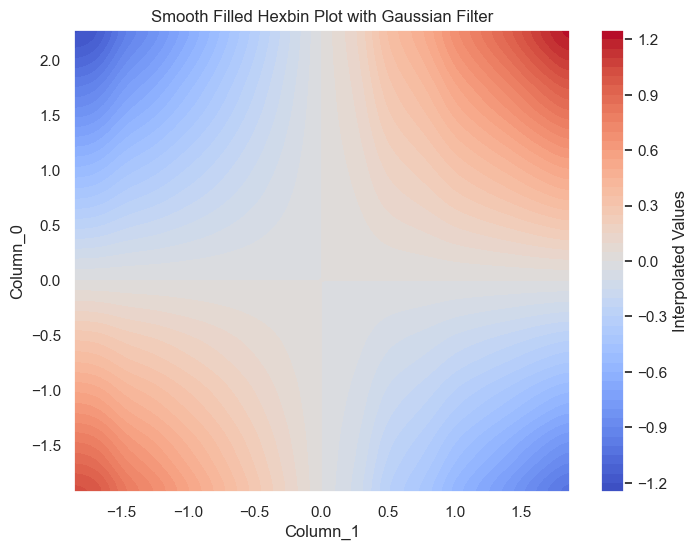

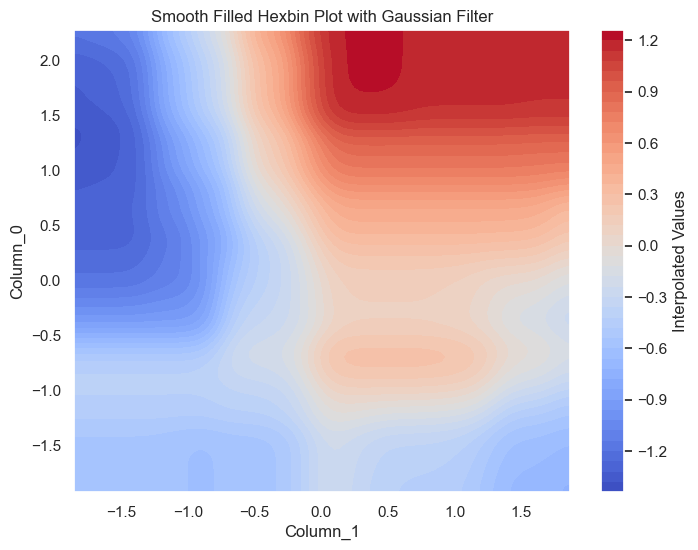

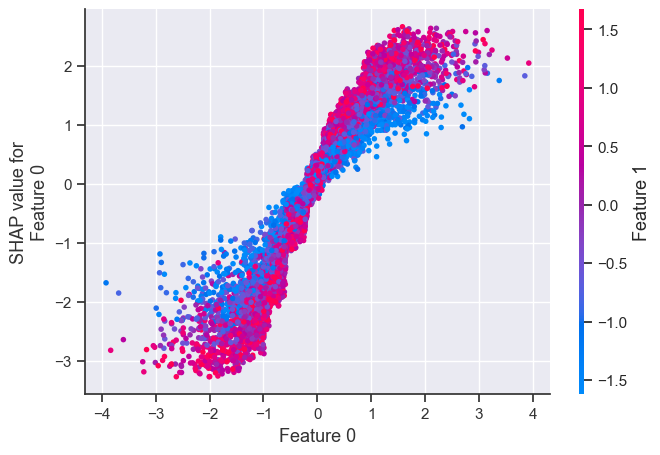

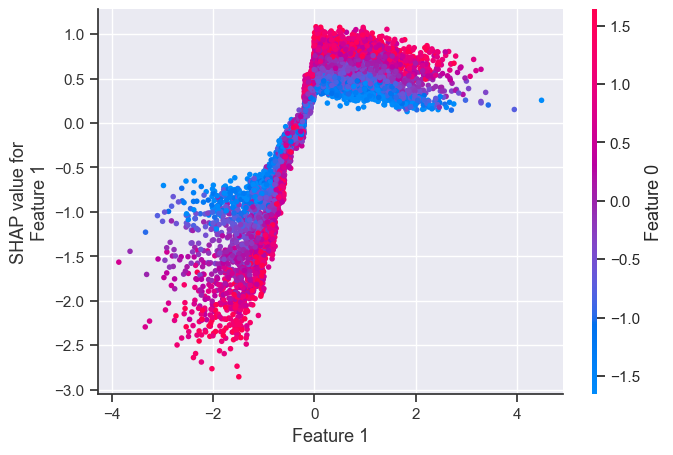

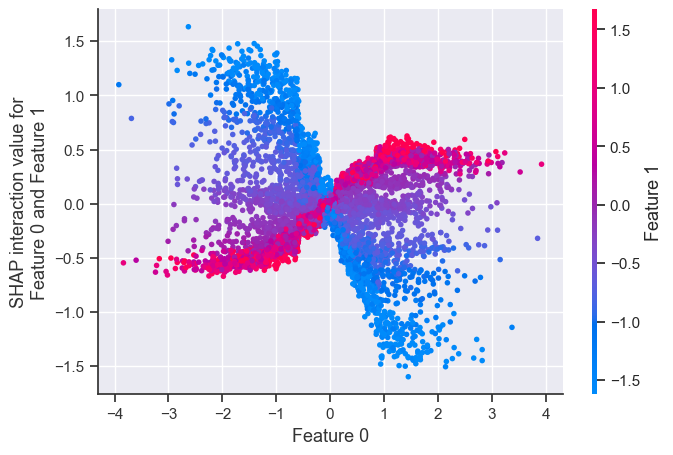

In [8]:
# Feature_0 ve Feature_1 arasındaki çarpan etkisini analiz et
df_01 = tree.analyze_dependency(0, 1)

# Orijinal veriyi kopyala ve etkileşimi tanımla
df_original_01 = df_01.copy()
df_original_01["values"] = 0.3 * df_original_01["Column_0"] * df_original_01["Column_1"]


# Etkileşim görselleştirme
plot_interaction(df_original_01)
plot_interaction(df_01)

# SHAP dependence plot (Tekil plot: Feature_0)
shap.dependence_plot(0, shap_values.values, X_train, interaction_index=1)

shap.dependence_plot(1, shap_values.values, X_train, interaction_index=0)

# SHAP dependence plot (İkili plot: Feature_0 ve Feature_1 etkileşimi)
shap.dependence_plot((0, 1), shap_interaction_values, X_train, display_features=X_train)


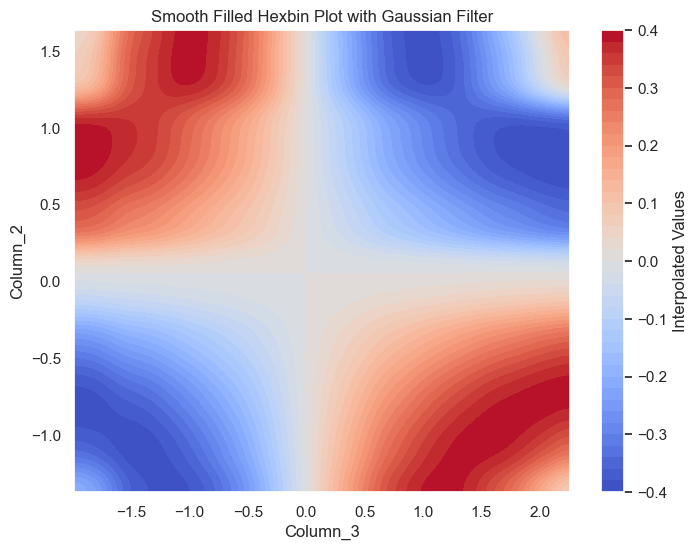

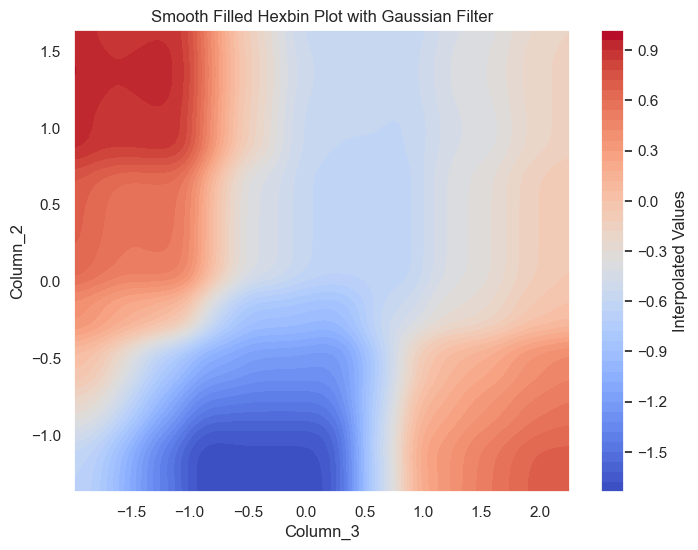

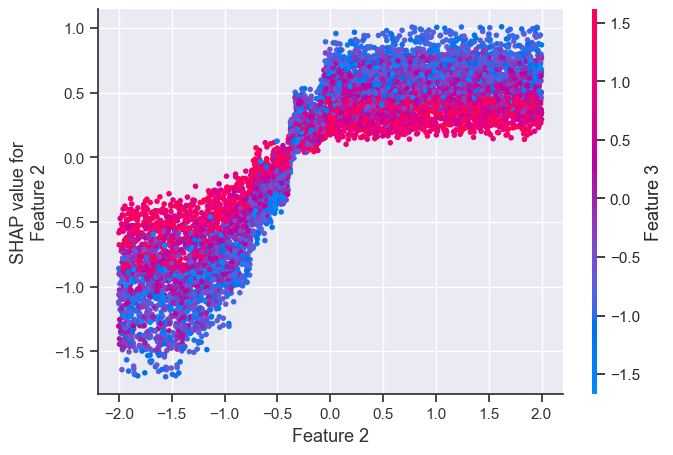

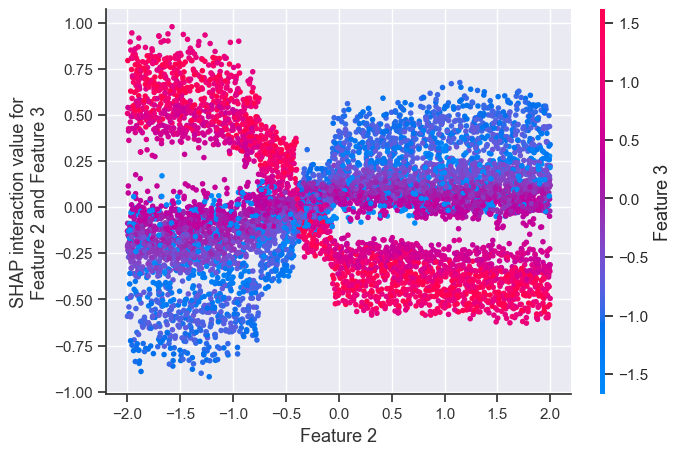

In [12]:
# Feature_2 ve Feature_3 arasındaki sinüs etkileşimini analiz et
df_23 = tree.analyze_dependency(2, 3)

# Orijinal veriyi kopyala ve etkileşimi tanımla
df_original_23 = df_23.copy()
df_original_23["values"] = -0.4 * np.sin(df_original_23["Column_2"] * df_original_23["Column_3"])

# Etkileşim görselleştirme
plot_interaction(df_original_23)
plot_interaction(df_23)

# SHAP dependence plot (Tekil plot: Feature_2)
shap.dependence_plot(2, shap_values.values, X_train, interaction_index=3)

# SHAP dependence plot (İkili plot: Feature_2 ve Feature_3 etkileşimi)
shap.dependence_plot((2, 3), shap_interaction_values, X_train, display_features=X_train)


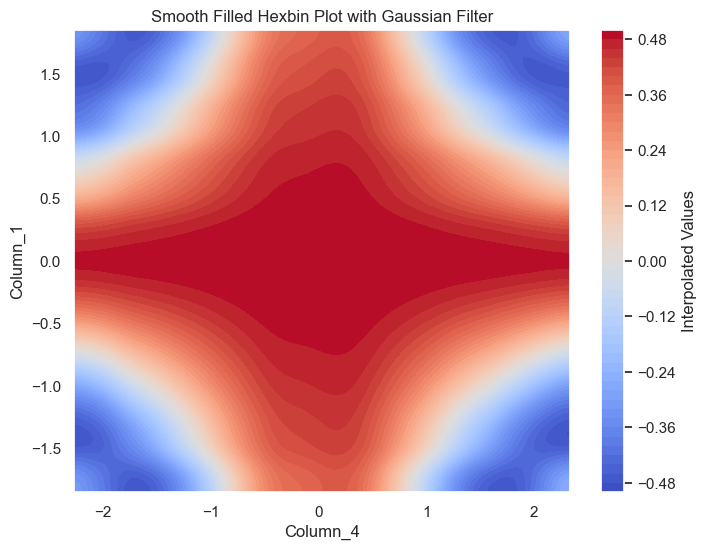

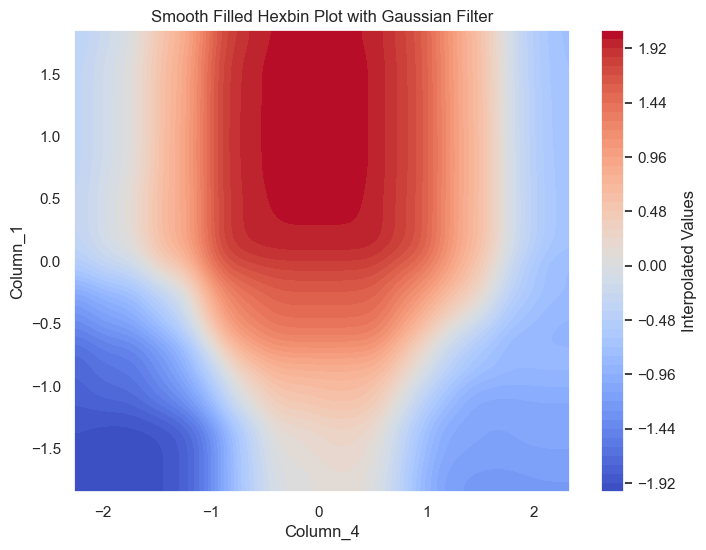

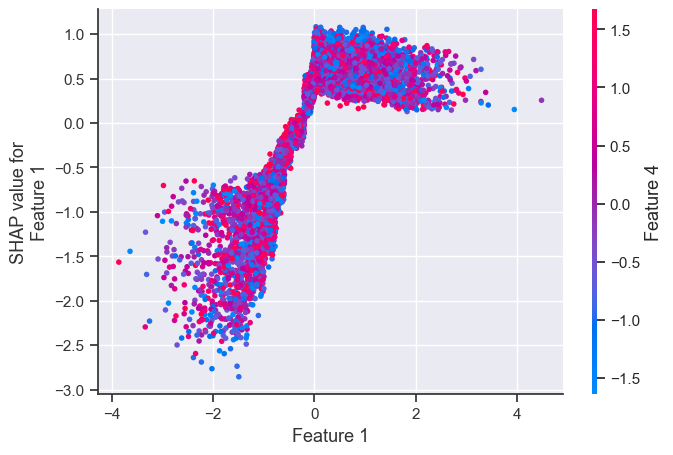

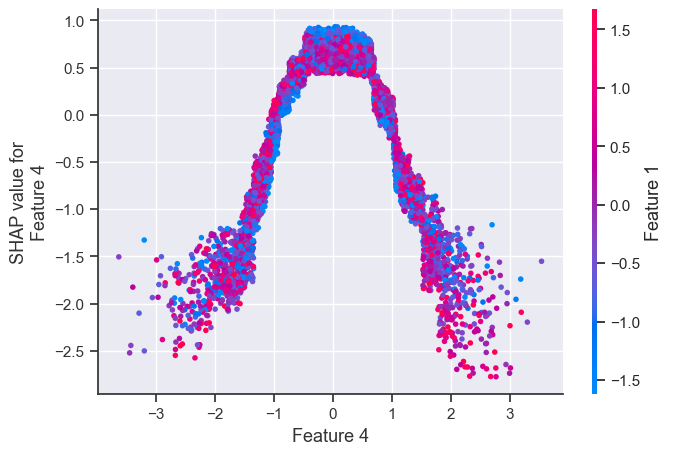

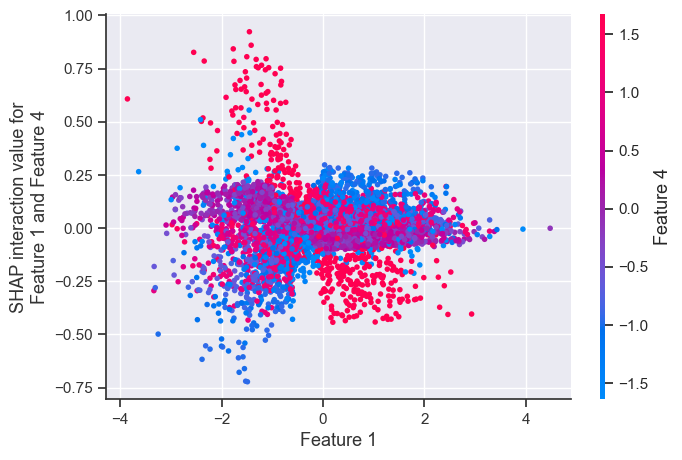

In [9]:
# Feature_1 ve Feature_4 arasındaki kosinüs etkileşimini analiz et
df_14 = tree.analyze_dependency(1, 4)

# Orijinal veriyi kopyala ve etkileşimi tanımla
df_original_14 = df_14.copy()
df_original_14["values"] = 0.5 * np.cos(-df_original_14["Column_1"] * df_original_14["Column_4"])

# Etkileşim görselleştirme
plot_interaction(df_original_14)
plot_interaction(df_14)

# SHAP dependence plot (Tekil plot: Feature_1)
shap.dependence_plot(1, shap_values.values, X_train, interaction_index=4)

shap.dependence_plot(4, shap_values.values, X_train, interaction_index=1)

# SHAP dependence plot (İkili plot: Feature_1 ve Feature_4 etkileşimi)
shap.dependence_plot((1, 4), shap_interaction_values, X_train, display_features=X_train)


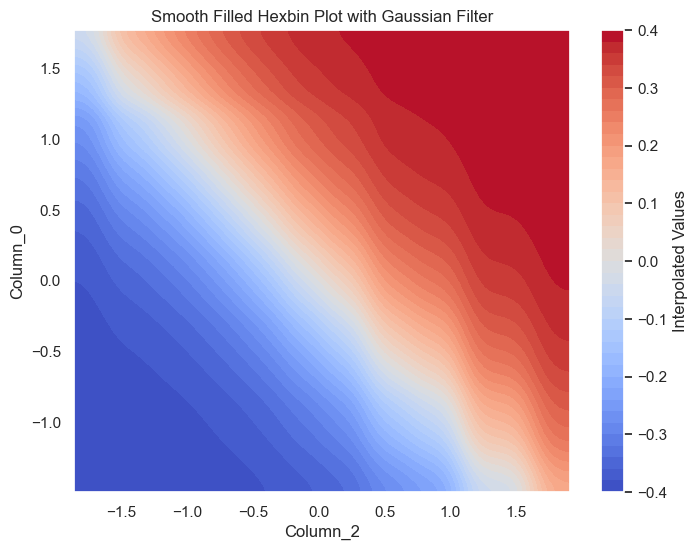

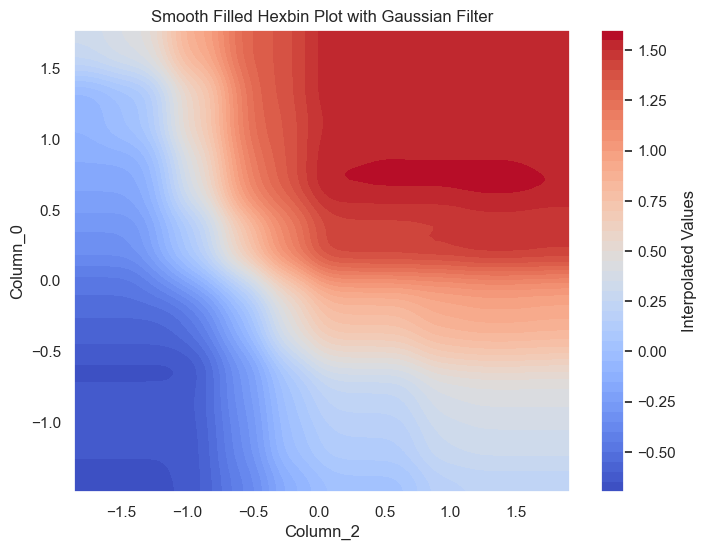

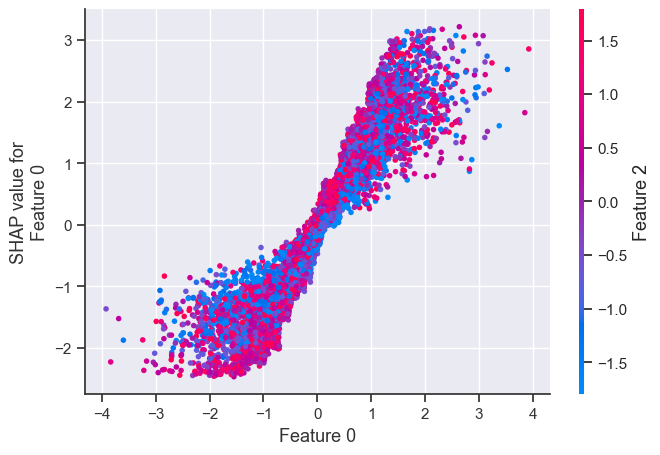

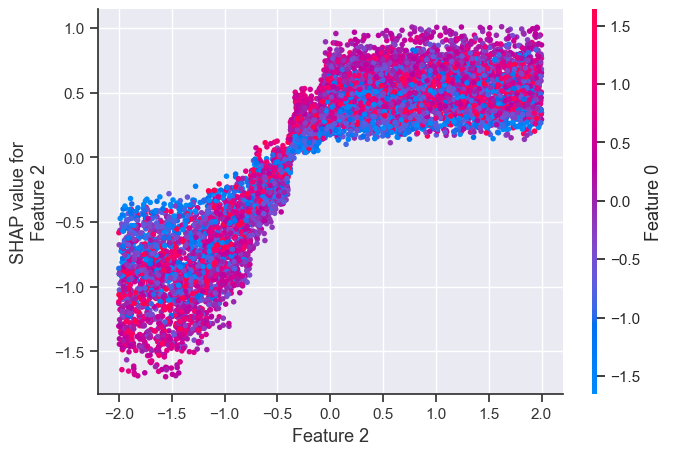

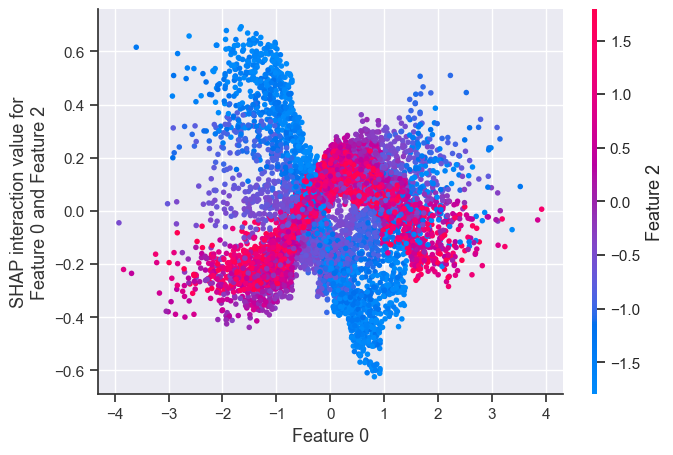

In [17]:
# Feature_0 ve Feature_2 arasındaki tanh birleşik etkisini analiz et
df_02 = tree.analyze_dependency(0, 2)

# Orijinal veriyi kopyala ve etkileşimi tanımla
df_original_02 = df_02.copy()
df_original_02["values"] = -0.4 * np.tanh(-(df_original_02["Column_0"] + df_original_02["Column_2"]))

# Etkileşim görselleştirme
plot_interaction(df_original_02)
plot_interaction(df_02)

# SHAP dependence plot (Tekil plot: Feature_0)
shap.dependence_plot(0, shap_values.values, X_train, interaction_index=2)
shap.dependence_plot(2, shap_values.values, X_train, interaction_index=0)

# SHAP dependence plot (İkili plot: Feature_0 ve Feature_2 etkileşimi)
shap.dependence_plot((0, 2), shap_interaction_values, X_train, display_features=X_train)


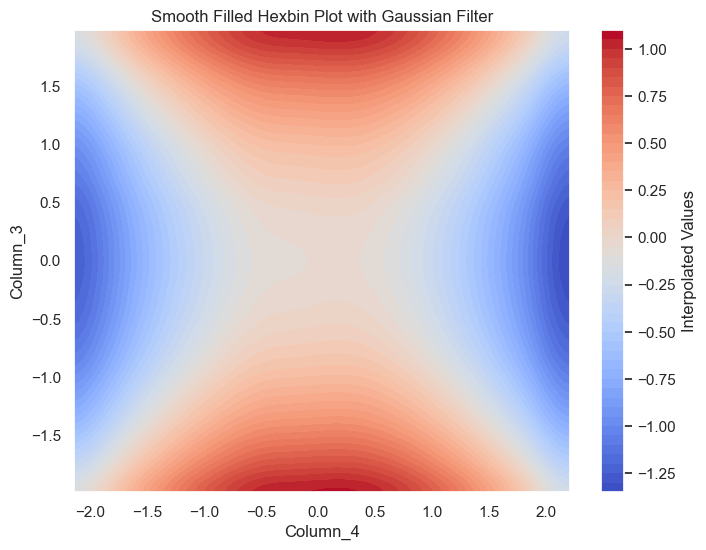

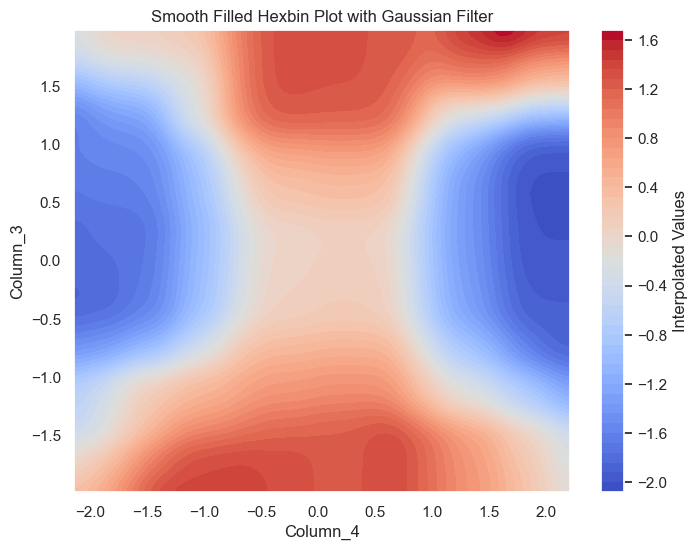

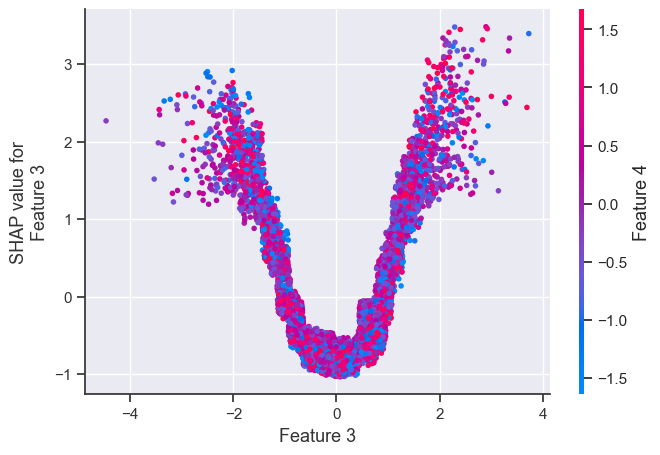

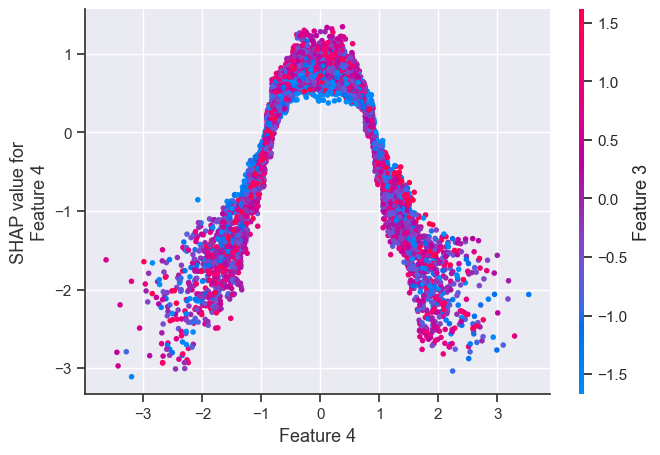

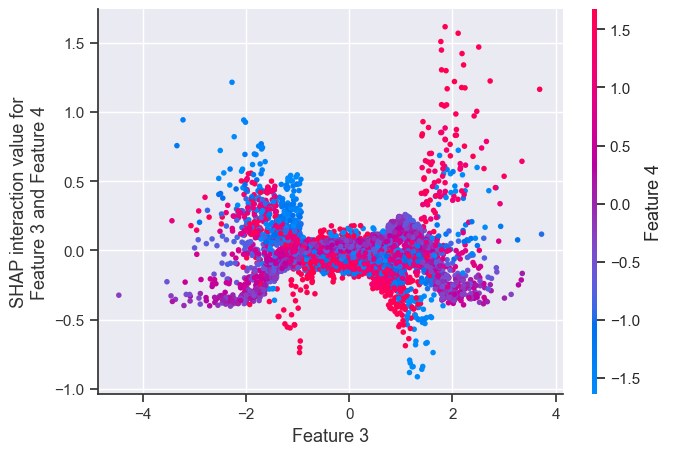

In [18]:
# Feature_3 ve Feature_4 arasındaki karesel etkileşimi analiz et
df_34 = tree.analyze_dependency(3, 4)

# Orijinal veriyi kopyala ve etkileşimi tanımla
df_original_34 = df_34.copy()
df_original_34["values"] = 0.3 * (df_original_34["Column_3"] ** 2 - df_original_34["Column_4"] ** 2)

# Etkileşim görselleştirme
plot_interaction(df_original_34)
plot_interaction(df_34)

# SHAP dependence plot (Tekil plot: Feature_3)
shap.dependence_plot(3, shap_values.values, X_train, interaction_index=4)
shap.dependence_plot(4, shap_values.values, X_train, interaction_index=3)


# SHAP dependence plot (İkili plot: Feature_3 ve Feature_4 etkileşimi)
shap.dependence_plot((3, 4), shap_interaction_values, X_train, display_features=X_train)


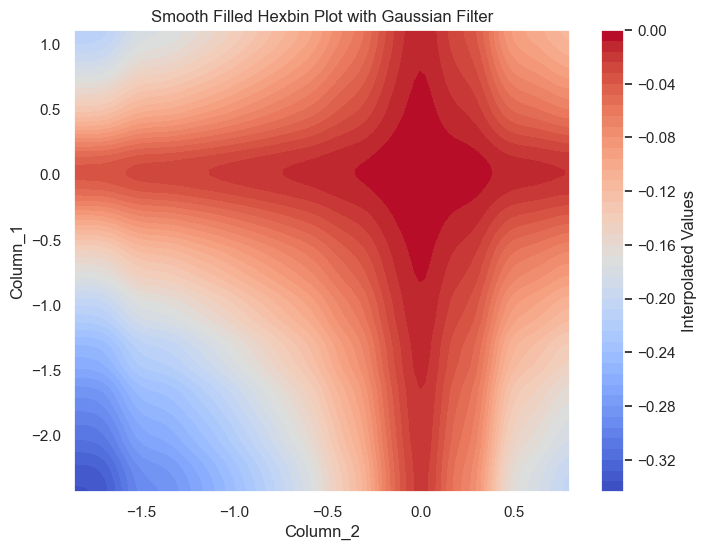

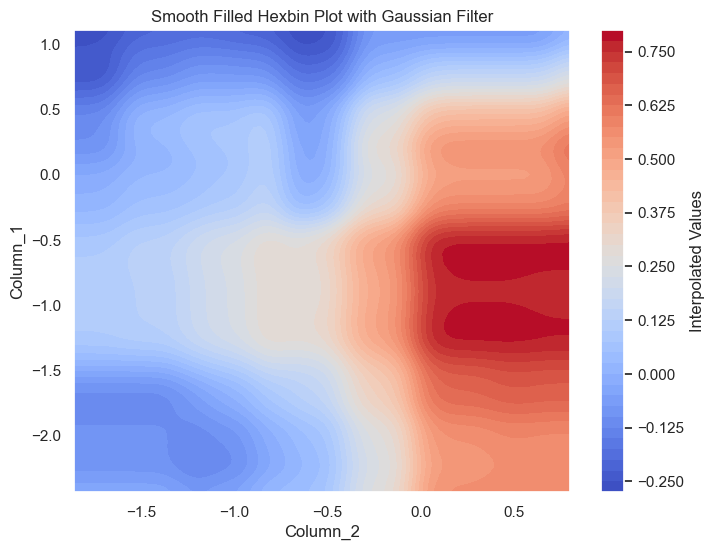

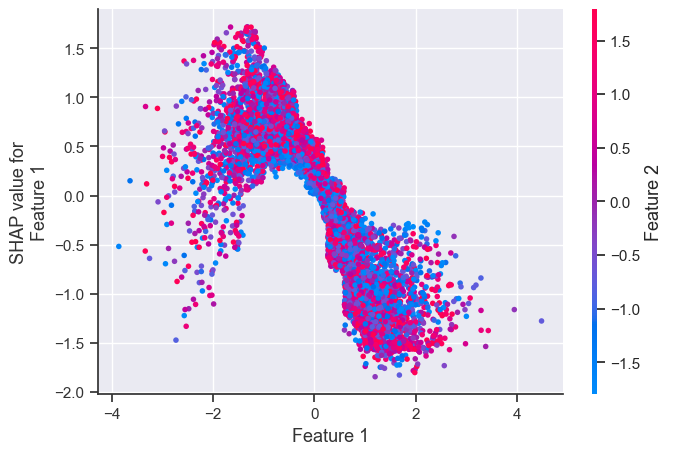

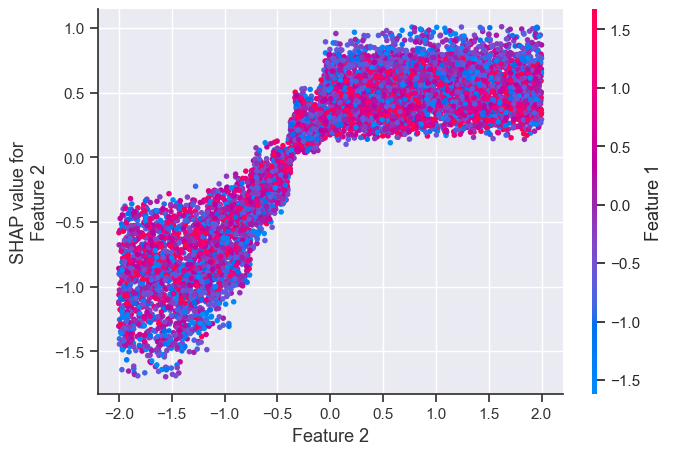

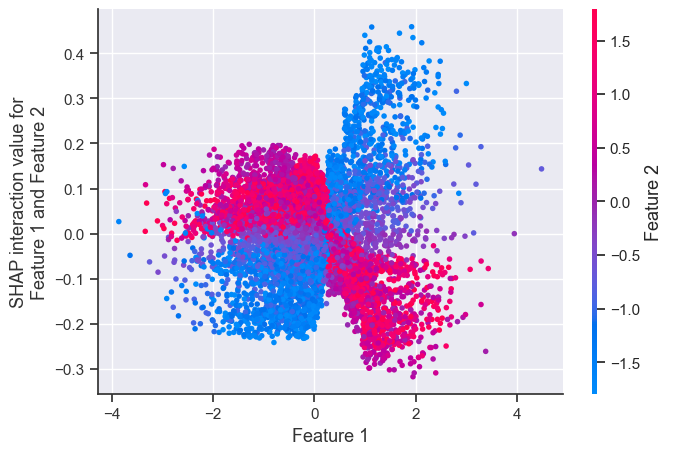

In [22]:
# Feature_1 ve Feature_2 arasındaki logaritmik etkileşimi analiz et
df_12 = tree.analyze_dependency(1, 2)

# Orijinal veriyi kopyala ve etkileşimi tanımla
df_original_12 = df_12.copy()
df_original_12["values"] = - 0.2 * np.log(np.abs(df_original_12["Column_1"] * df_original_12["Column_2"]) + 1)

# Etkileşim görselleştirme
plot_interaction(df_original_12)
plot_interaction(df_12)

# SHAP dependence plot (Tekil plot: Feature_1)
shap.dependence_plot(1, shap_values.values, X_train, interaction_index=2)
shap.dependence_plot(2, shap_values.values, X_train, interaction_index=1)

# SHAP dependence plot (İkili plot: Feature_1 ve Feature_2 etkileşimi)
shap.dependence_plot((1, 2), shap_interaction_values, X_train, display_features=X_train)
